In [1]:
# !pip install pgmpy==0.1.16
# !pip install scikit-learn==1.1.0 --user
# !pip install pandas==1.4.1

In [2]:
import pgmpy
import numpy as np
from gmr import GMM
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
import seaborn as sns
from pgmpy.metrics import log_likelihood_score
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import HillClimbSearch, K2Score
import math

%matplotlib inline
import bamt.Networks as Nets
import bamt.Preprocessors as pp


from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import networkx as nx
import random

from sklearn.model_selection import train_test_split


import random
import string

In [3]:
def generate_random_dag(n, p):
    # генерируем случайное дерево
    edges = []
    for i in range(1, n):
        parent = random.randint(0, i - 1)
        edges.append((parent, i))

    # добавляем случайные ребра, пока не получим DAG
    while True:
        new_edge = (random.randint(0, n-1), random.randint(0, n-1))
        #if new_edge[0] >= new_edge[1]:
            #continue  # не добавляем обратное ребро
        if new_edge in edges:
            continue  # не добавляем дубликат ребра
        edges.append(new_edge)
        if is_dag(n, edges): # and len(edges) > int(n*1.5):
            if n > 4:
                if len(edges) >= int(n*(1+random.random())):
                    break
            else:
                break
        else:
            edges.remove(new_edge)
    return edges

def is_dag(n, edges):
    G = nx.DiGraph(edges)
    return nx.is_directed_acyclic_graph(G)

In [4]:
def generate_samples(k_samples=2):
    """
    Случайная смесь Гауссовских распределений
    """
    
    # Определение параметров смеси гауссовских распределений
    n_components = random.randint(1, 4) # количество компонентов в смеси

    # Генерация случайных значений для means
    means = np.random.uniform(low=-1, high=1, size=n_components)

    # Генерация случайных значений для covs
    covs = np.random.uniform(low=0.5, high=1, size=n_components)

    # Генерация случайных значений для weights
    weights = np.random.dirichlet(np.ones(n_components), size=1)[0]

    # Создание смеси гауссовских распределений
    from sklearn.mixture import GaussianMixture

    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.means_ = means.reshape(-1, 1)  # преобразование вектора средних значений в столбец
    gmm.covariances_ = np.square(covs).reshape(-1, 1, 1)  # преобразование вектора дисперсий в матрицы ковариации
    gmm.weights_ = weights

    # Генерация случайной выборки из смеси гауссовских распределений
    X, y = gmm.sample(n_samples=10**k_samples) #10^6

#     print(f'количество компонентов в смеси: {n_components}')
#     print(f'средние значения гауссовских распределений: {means}')
#     print(f'Ковариации: {covs}')
#     print(f'Веса: {weights}')

#     Визуализация сгенерированной выборки
#     import matplotlib.pyplot as plt

#     plt.hist(X, bins=20)
#     plt.show()
    
    return X.reshape([1,-1])[0]

In [5]:
def linear_func(x, k_samples=2):
    
    x = np.array(x)
    a = [random.random()*2-1 for i in x]
    b = [random.random()*2-1 for i in x]
    noise = np.array([np.random.normal(loc=0, scale = 1) for x in range(10**k_samples)]) #**6

    res = sum([a[i]*x[:,i] + b[i] for i in range(x.shape[1])]) + noise
    return res

In [6]:
def init_edges(edges):
    final = [0]*len(edges)
    for ind, edge in enumerate(edges):
        final[ind] = (str(edge[0]) + '_', str(edge[1]) + '_')
    return final

In [7]:
def create_dag(n_nodes, p):
    edges = generate_random_dag(n_nodes, p)
#     print(len(edges))
    G = nx.DiGraph(edges)
    assert nx.is_directed_acyclic_graph(G)
    return G, edges

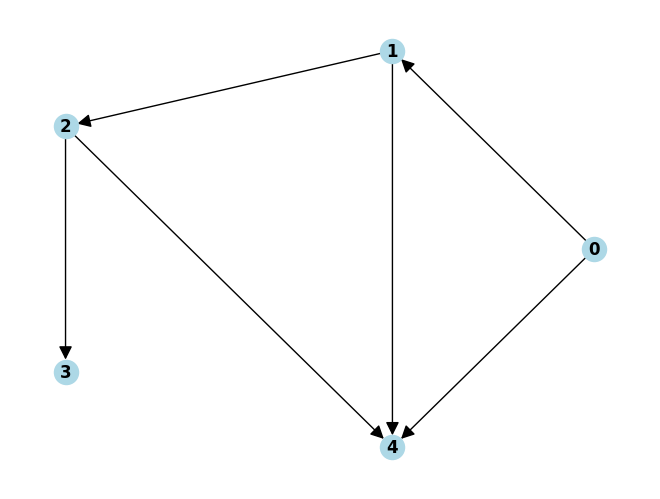

In [200]:
# создаем графическое представление
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', font_weight='bold', font_size=12, arrowsize=20)

plt.savefig(f'{folder}/{filename_true_structure}_{name_exp}.png')
plt.show()

In [8]:
def create_dataset(edges, k_samples=2):
    connections_to = {}
    connections_from ={}
    edges.sort()
    for ind, edge in enumerate(edges):
        connections_from[ind] = [edges[x][1] for x in range(len(edges)) if edges[x][0]==ind]
        connections_to[ind] = [edges[x][0] for x in range(len(edges)) if edges[x][1]==ind]

    df = pd.DataFrame(generate_samples(k_samples), columns=[str(edges[0][0])])
    remaining_nodes = np.arange(1, n_nodes)
    for i in connections_from[0]:
        if len(connections_to[i]) == 1:
            x = (df[['0']])
            temp_df = pd.DataFrame(linear_func(x, k_samples), columns=[str(i)])
            df = pd.concat([df, temp_df], axis=1)
            remaining_nodes = np.delete(remaining_nodes, np.where(remaining_nodes==i))


    ind = 0
#     print(remaining_nodes)
    while len(remaining_nodes) > 0:
        k = remaining_nodes[ind]
        last_nodes = df.columns
        if len([x for x in connections_to[k] if str(x) in last_nodes]) == len(connections_to[k]):
#             print(str(k))
            x = np.array([0.0]*10**k_samples) #**6
#             print(connections_to[k])
            x = df[list(map(str, connections_to[k]))]
            temp_df = pd.DataFrame(linear_func(x, k_samples), columns=[str(k)])
            df = pd.concat([df, temp_df], axis=1)
            remaining_nodes = np.delete(remaining_nodes, np.where(remaining_nodes==k))
#             print(k)
        else:
            ind += 1
        if ind >= len(remaining_nodes):
            ind = 0
    
    return df

In [9]:
def desc_data(values, columns):
    disc_model = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
    disc_model.fit(values)
    sample_disc = pd.DataFrame(disc_model.transform(values), columns=columns)

    return sample_disc

In [74]:
model_init = BayesianNetwork(init_edges(edges))


model_init.fit(
    data=sample_disc,
    estimator=MaximumLikelihoodEstimator
)


In [209]:
Score_init = log_likelihood_score(model_init, sample_disc)
Score_init

-636.9013346129608

In [211]:
samping_model = BayesianModelSampling(model_init)

In [212]:
test = samping_model.forward_sample(10**k)
test

  0%|          | 0/5 [00:00<?, ?it/s]

,0_,1_,4_,2_,3_
0,2.0,4.0,0.0,4.0,4.0
1,2.0,2.0,4.0,2.0,1.0
2,4.0,1.0,2.0,3.0,4.0
3,0.0,0.0,4.0,0.0,4.0
4,0.0,3.0,0.0,2.0,1.0
...,...,...,...,...,...
9995,0.0,0.0,4.0,0.0,4.0
9996,4.0,3.0,4.0,4.0,2.0
9997,4.0,4.0,2.0,2.0,3.0
9998,4.0,4.0,4.0,3.0,1.0


In [213]:
size = 100
train = samping_model.forward_sample(size)
est = HillClimbSearch(train)
G_sample = BayesianNetwork(est.estimate(scoring_method=K2Score(train)))
G_sample.fit(data=train,estimator=MaximumLikelihoodEstimator)
score_sample = 0
try:
    score_sample = log_likelihood_score(G_sample, test)  
    print(f'size = {size}')
except:
    score_sample = -1*np.inf
print(Score_init - score_sample)
#delts.append(Score_init - score_sample)  

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

size = 100
inf


In [10]:
def create_delts(Score_init, samping_model, test, k_samples=2):
    delts = []
    start = 4
    end = 10**k_samples
    step = 100
    for size in range(start, end, step):
        train = samping_model.forward_sample(size)
        est = HillClimbSearch(train)
        G_sample = BayesianNetwork(est.estimate(scoring_method=K2Score(train)))
        G_sample.fit(data=train,estimator=MaximumLikelihoodEstimator)
        score_sample = 0
        try:
            score_sample = log_likelihood_score(G_sample, test)  
#             print(f'size = {size}')
#             print(score_sample)
        except:
            score_sample = -1*np.inf
        delta = (round(Score_init - score_sample, 3))
        print(size)
        print(delta)
        delts.append(delta)
    
    return delts, G_sample
    

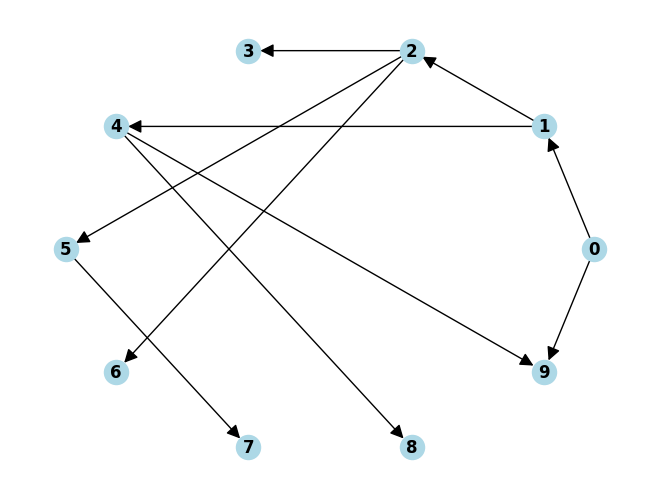

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

204
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

904
9128.684


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1204
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1404
8066.9


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2104
5028.472


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2204
5331.755


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2304
4727.369


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2904
3316.065


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3004
3678.974


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3104
3051.793


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3204
3641.368


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3504
3259.045


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3604
3468.157


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3804
3249.479


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4104
2715.704


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4204
3242.91


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4304
2845.84


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4404
3230.095


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4504
2740.278


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4604
3153.593


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4704
2592.07


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4804
2527.186


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5004
2237.332


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5204
2710.99


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5304
2545.819


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5404
2166.572


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5604
2280.576


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5704
2628.093


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5804
2425.048


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5904
2839.934


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6204
2035.681


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6304
2091.158


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6504
2143.866


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6604
2341.657


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6704
2087.726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6804
1870.029


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6904
1921.012


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7104
2431.978


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7204
1541.664


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7304
1873.906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7404
1727.242


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7504
1580.413


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7604
1923.599


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7704
1602.069


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7904
1967.632


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8004
1924.46


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8104
1572.287


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8204
1823.217


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8304
1619.721


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8404
1443.923


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8604
1646.986


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8704
1587.467


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9004
1561.909


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9104
1536.236


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9204
1411.294


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9404
1569.415


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9504
1541.229


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9604
1374.443


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9704
1540.843


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9804
1470.899


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9904
1329.65


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10004
1427.964


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10204
1581.591


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10304
1373.527


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10404
1174.126


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10504
1209.533


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10704
1225.231


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10804
1267.077


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

47504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

47604
695.225


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

47704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

47804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

47904
687.568


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48004
116.504


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48104
721.023


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48204
137.534


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48304
733.955


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48404
121.826


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48504
112.084


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48604
130.385


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48704
165.728


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48804
114.681


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48904
151.906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49004
189.363


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49104
746.563


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49204
99.236


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49304
756.435


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49404
186.081


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49504
199.063


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49604
184.119


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49704
113.548


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49804
721.04


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50004
737.985


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50104
180.644


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50204
136.018


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50304
154.581


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50404
82.741


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50604
149.151


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50704
114.146


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50804
660.402


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50904
108.586


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51004
718.454


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51104
756.957


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51204
169.797


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51304
676.597


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51404
94.975


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51504
149.258


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51604
743.073


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51704
135.733


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51804
676.692


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51904
83.623


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52004
70.574


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52104
103.429


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52204
660.899


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52304
640.035


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52404
644.871


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52504
207.313


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52604
697.829


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52704
95.618


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52804
99.1


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52904
104.72


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53004
72.908


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53104
110.086


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53204
143.064


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53304
87.02


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53404
88.752


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53504
96.263


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53604
652.096


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53704
774.56


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53804
149.028


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53904
650.211


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

54004
666.913


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

54104
176.019


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

54204
766.153


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

54304
680.74


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

54404
102.426


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

54504
719.904


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

54604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

54704
105.74


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

54804
142.879


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

54904
80.803


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

55004
660.705


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

55104
703.505


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

55204
97.641


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

55304
98.699


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

55404
126.291


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

55504
93.317


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

55604
172.727


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

55704
107.636


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

55804
674.235


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

55904
682.389


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

56004
676.483


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

56104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

56204
96.844


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

56304
337.64


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

56404
73.738


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

56504
96.812


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

56604
103.882


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

56704
694.363


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

56804
179.827


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

56904
41.983


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

57004
742.025


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

57104
741.828


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

57204
73.076


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

57304
604.716


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

57404
108.562


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

57504
62.622


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

57604
114.915


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

57704
633.09


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

57804
691.125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

57904
90.957


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

58004
88.254


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

58104
749.927


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

58204
106.443


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

58304
145.942


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

58404
662.243


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

58504
52.373


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

58604
613.063


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

58704
729.25


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

58804
109.102


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

58904
104.096


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

59004
131.683


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

59104
701.783


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

59204
39.414


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

59304
120.677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

59404
139.642


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

59504
676.497


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

59604
760.073


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

59704
78.538


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

59804
49.272


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

59904
96.103


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

60004
595.611


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

60104
723.84


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

60204
95.988


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

60304
714.545


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

60404
62.133


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

60504
54.338


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

60604
82.693


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

60704
79.217


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

60804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

60904
650.44


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

61004
82.924


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

61104
608.231


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

61204
70.173


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

61304
149.404


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

61404
654.748


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

61504
13.511


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

61604
615.456


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

61704
84.163


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

61804
623.195


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

61904
111.555


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

62004
48.793


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

62104
31.375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

62204
640.666


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

62304
22.864


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

62404
158.298


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

62504
100.166


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

62604
59.739


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

62704
103.504


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

62804
152.171


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

62904
687.483


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

63004
696.989


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

63104
139.592


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

63204
79.461


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

63304
729.808


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

63404
605.578


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

63504
72.906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

63604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

63704
673.555


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

63804
49.859


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

63904
726.652


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

64004
142.545


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

64104
45.083


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

64204
656.179


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

64304
96.052


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

64404
601.896


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

64504
590.025


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

64604
91.264


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

64704
70.367


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

64804
661.222


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

64904
661.209


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

65004
6.432


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

65104
690.481


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

65204
64.524


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

65304
37.275


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

65404
79.556


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

65504
63.776


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

65604
91.83


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

65704
685.296


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

65804
71.084


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

65904
100.991


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

66004
652.467


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

66104
60.854


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

66204
75.618


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

66304
56.047


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

66404
626.151


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

66504
79.198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

66604
70.422


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

66704
665.131


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

66804
701.526


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

66904
44.527


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

67004
652.069


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

67104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

67204
359.141


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

67304
61.974


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

67404
28.183


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

67504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

67604
93.372


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

67704
49.827


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

67804
34.467


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

67904
698.116


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

68004
90.157


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

68104
611.397


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

68204
28.771


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

68304
586.577


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

68404
38.547


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

68504
53.775


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

68604
78.496


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

68704
91.875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

68804
333.781


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

68904
69.537


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

69004
731.086


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

69104
684.062


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

69204
61.909


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

69304
45.812


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

69404
17.466


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

69504
31.975


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

69604
66.105


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

69704
46.692


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

69804
405.058


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

69904
82.647


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

70004
61.466


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

70104
61.006


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

70204
87.677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

70304
97.137


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

70404
27.998


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

70504
11.445


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

70604
21.063


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

70704
108.453


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

70804
53.347


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

70904
122.234


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

71004
28.299


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

71104
66.957


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

71204
90.053


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

71304
43.013


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

71404
-12.559


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

71504
53.471


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

71604
31.253


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

71704
17.219


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

71804
24.647


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

71904
47.854


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

72004
644.101


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

72104
667.897


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

72204
39.365


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

72304
647.402


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

72404
57.912


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

72504
105.861


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

72604
289.651


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

72704
-13.338


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

72804
17.172


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

72904
40.445


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

73004
603.37


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

73104
2.158


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

73204
631.462


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

73304
69.781


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

73404
712.648


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

73504
324.807


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

73604
63.054


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

73704
704.857


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

73804
624.125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

73904
691.203


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

74004
52.207


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

74104
-3.459


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

74204
52.465


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

74304
-6.242


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

74404
625.174


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

74504
312.015


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

74604
638.32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

74704
641.008


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

74804
6.358


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

74904
87.939


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

75004
28.013


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

75104
77.138


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

75204
381.358


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

75304
646.772


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

75404
11.059


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

75504
630.571


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

75604
418.499


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

75704
-6.561


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

75804
348.301


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

75904
304.466


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

76004
705.49


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

76104
611.712


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

76204
607.987


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

76304
620.345


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

76404
75.662


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

76504
-3.082


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

76604
696.429


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

76704
28.355


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

76804
369.006


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

76904
349.135


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

77004
29.953


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

77104
95.368


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

77204
50.719


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

77304
331.301


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

77404
22.476


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

77504
7.677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

77604
20.498


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

77704
301.712


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

77804
309.036


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

77904
318.835


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

78004
400.131


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

78104
87.412


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

78204
5.463


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

78304
12.75


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

78404
277.711


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

78504
612.075


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

78604
654.159


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

78704
317.923


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

78804
15.865


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

78904
356.421


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

79004
24.195


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

79104
-19.806


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

79204
7.093


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

79304
288.974


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

79404
33.32


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

79504
376.449


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

79604
592.01


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

79704
61.406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

79804
67.662


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

79904
329.681


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

80004
32.983


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

80104
23.738


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

80204
23.86


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

80304
8.387


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

80404
29.812


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

80504
666.428


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

80604
11.557


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

80704
89.431


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

80804
359.153


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

80904
54.244


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

81004
9.551


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

81104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

81204
4.653


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

81304
61.14


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

81404
14.09


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

81504
34.908


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

81604
41.532


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

81704
651.249


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

81804
8.133


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

81904
619.519


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

82004
-9.35


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

82104
602.912


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

82204
87.201


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

82304
622.056


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

82404
21.717


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

82504
47.168


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

82604
301.096


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

82704
39.57


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

82804
615.412


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

82904
30.94


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

83004
-0.654


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

83104
305.398


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

83204
285.671


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

83304
0.442


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

83404
376.482


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

83504
281.406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

83604
16.37


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

83704
-11.103


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

83804
15.674


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

83904
414.079


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

84004
-18.868


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

84104
328.062


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

84204
6.331


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

84304
-9.94


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

84404
326.242


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

84504
22.634


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

84604
351.926


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

84704
587.692


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

84804
-13.47


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

84904
30.291


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

85004
323.085


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

85104
11.61


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

85204
6.706


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

85304
19.979


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

85404
335.162


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

85504
32.404


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

85604
272.081


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

85704
-4.281


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

85804
-7.039


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

85904
26.618


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

86004
-0.864


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

86104
-9.323


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

86204
-2.519


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

86304
9.372


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

86404
339.512


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

86504
579.497


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

86604
291.332


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

86704
25.234


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

86804
312.197


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

86904
323.966


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

87004
-19.21


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

87104
13.079


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

87204
34.221


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

87304
312.507


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

87404
360.954


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

87504
-22.463


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

87604
13.372


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

87704
14.226


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

87804
371.484


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

87904
365.277


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

88004
42.504


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

88104
-20.69


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

88204
318.029


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

88304
30.971


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

88404
8.273


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

88504
3.897


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

88604
304.391


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

88704
9.677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

88804
305.259


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

88904
-7.003


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

89004
266.387


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

89104
-18.115


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

89204
16.008


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

89304
16.463


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

89404
308.352


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

89504
5.04


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

89604
630.285


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

89704
309.725


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

89804
3.65


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

89904
36.515


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

90004
46.678


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

90104
26.265


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

90204
306.457


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

90304
10.674


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

90404
338.346


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

90504
371.255


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

90604
315.468


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

90704
69.416


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

90804
29.276


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

90904
386.686


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

91004
309.641


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

91104
287.176


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

91204
-27.8


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

91304
42.391


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

91404
319.898


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

91504
352.712


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

91604
275.051


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

91704
29.152


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

91804
299.261


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

91904
257.35


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

92004
616.887


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

92104
15.233


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

92204
-29.587


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

92304
304.188


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

92404
6.117


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

92504
41.656


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

92604
28.274


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

92704
14.702


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

92804
302.402


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

92904
343.513


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

93004
1.064


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

93104
37.738


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

93204
247.017


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

93304
43.71


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

93404
609.841


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

93504
-34.451


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

93604
7.608


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

93704
-16.712


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

93804
20.363


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

93904
253.301


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

94004
7.437


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

94104
-1.502


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

94204
329.042


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

94304
31.96


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

94404
279.656


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

94504
14.026


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

94604
266.244


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

94704
307.922


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

94804
16.527


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

94904
-13.767


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

95004
10.847


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

95104
31.132


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

95204
263.796


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

95304
70.15


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

95404
20.222


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

95504
-22.276


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

95604
255.471


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

95704
-10.861


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

95804
11.202


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

95904
37.713


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

96004
61.094


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

96104
309.76


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

96204
15.73


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

96304
333.788


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

96404
322.581


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

96504
328.093


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

96604
-15.44


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

96704
334.068


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

96804
33.858


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

96904
293.301


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

97004
336.834


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

97104
-21.916


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

97204
17.037


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

97304
289.857


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

97404
-0.101


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

97504
-28.686


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

97604
283.315


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

97704
295.903


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

97804
-7.444


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

97904
233.839


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

98004
-25.564


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

98104
3.253


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

98204
-33.843


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

98304
-37.282


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

98404
12.281


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

98504
-40.522


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

98604
28.384


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

98704
-25.241


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

98804
-21.243


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

98904
282.304


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

99004
362.537


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

99104
-12.726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

99204
27.771


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

99304
20.468


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

99404
-48.962


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

99504
302.01


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

99604
276.854


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

99704
17.759


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

99804
-17.73


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

99904
284.566



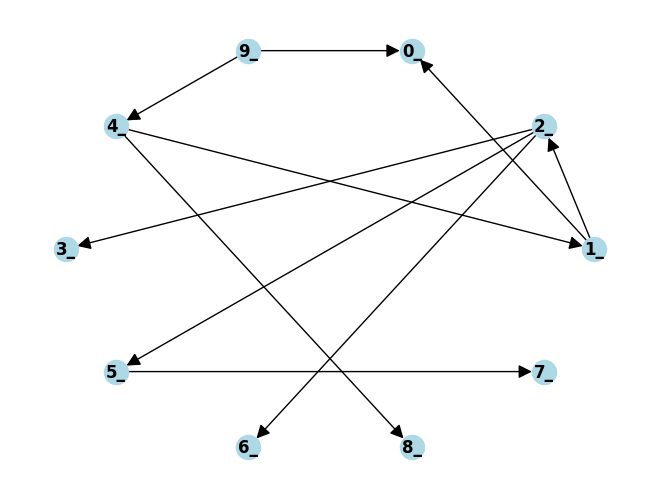

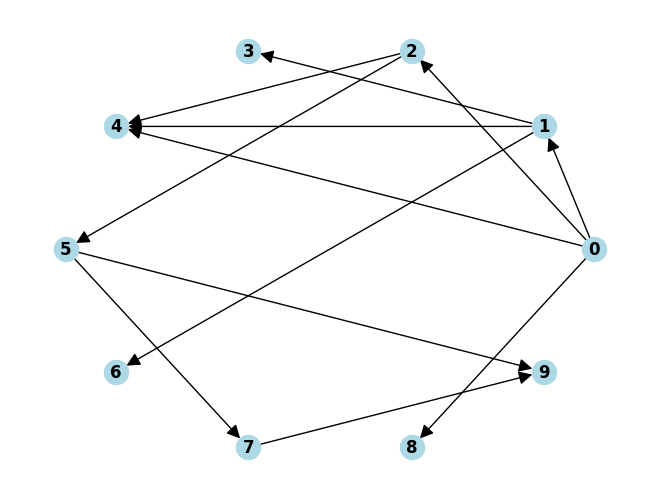

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

204
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1204
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

1904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2104
7537.291


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2204
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2304
7258.44


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2404
7042.859


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2604
7438.67


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

2904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3204
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3604
6722.207


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

3904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4204
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4804
3217.289


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

4904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5204
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5304
2966.175


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

5904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6204
2697.428


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6304
2830.665


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6404
2736.489


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6604
2741.442


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

6904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7004
2230.304


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7104
2228.477


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7204
2453.71


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7604
2290.152


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

7904
2386.861


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8204
2158.759


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8404
1943.157


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8504
2237.235


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8604
1960.087


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8804
1950.975


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

8904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9104
3503.441


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9204
2065.214


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9404
2147.834


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9504
2158.261


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9604
1839.746


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9704
1851.962


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9804
3656.329


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

9904
1996.837


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10004
1943.413


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10104
1722.233


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10204
1706.406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10404
1909.107


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10504
1880.818


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10604
1567.558


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10704
2137.333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10804
1795.882


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

10904
1501.886


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

11004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

11104
1909.053


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

11204
1641.182


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

11304
1703.018


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

11404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

11504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

11604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

11704
1653.273


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

11804
1710.293


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

11904
1646.715


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

12004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

12104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

12204
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

12304
1751.454


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

12404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

12504
1696.986


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

12604
1557.467


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

12704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

12804
1647.078


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

12904
1856.018


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

13004
1747.259


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

13104
1533.808


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

13204
1615.834


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

13304
1444.202


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

13404
1587.056


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

13504
1476.906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

13604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

13704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

13804
1459.701


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

13904
1545.358


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

14004
1556.578


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

14104
1346.653


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

14204
1383.013


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

14304
1396.106


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

14404
1350.453


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

14504
1518.721


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

14604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

14704
1461.152


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

14804
1370.524


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

14904
1390.141


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

15004
1329.245


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

15104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

15204
1465.483


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

15304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

15404
1415.165


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

15504
1233.634


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

15604
1582.585


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

15704
1378.971


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

15804
1366.665


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

15904
1274.785


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

16004
1273.406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

16104
1309.238


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

16204
1426.056


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

16304
1435.089


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

16404
1349.535


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

16504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

16604
1436.181


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

16704
1378.218


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

16804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

16904
1255.225


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

17004
1305.049


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

17104
1414.226


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

17204
1327.456


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

17304
1191.818


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

17404
1299.839


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

17504
1376.582


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

17604
1324.411


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

17704
1311.402


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

17804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

17904
1297.226


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

18004
1419.018


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

18104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

18204
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

18304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

18404
1501.053


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

18504
1276.561


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

18604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

18704
1464.039


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

18804
1250.473


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

18904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

19004
1273.169


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

19104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

19204
1313.989


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

19304
1374.894


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

19404
1348.436


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

19504
1151.78


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

19604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

19704
1232.229


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

19804
1237.13


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

19904
1162.858


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

20004
1142.665


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

20104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

20204
1204.779


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

20304
1299.697


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

20404
1214.743


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

20504
1249.246


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

20604
1192.397


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

20704
1227.078


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

20804
1077.654


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

20904
1140.347


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

21004
1191.487


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

21104
1115.907


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

21204
1157.604


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

21304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

21404
1043.084


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

21504
1187.942


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

21604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

21704
1281.575


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

21804
1185.049


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

21904
1179.53


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

22004
1157.411


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

22104
1206.5


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

22204
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

22304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

22404
1117.868


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

22504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

22604
1552.916


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

22704
1100.843


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

22804
1235.263


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

22904
1157.839


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

23004
1194.353


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

23104
1114.957


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

23204
1000.956


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

23304
1111.784


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

23404
1258.411


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

23504
1055.73


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

23604
1105.398


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

23704
1132.194


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

23804
1047.753


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

23904
1169.857


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

24004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

24104
1107.812


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

24204
1073.701


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

24304
1081.872


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

24404
949.381


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

24504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

24604
1103.893


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

24704
1014.053


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

24804
1195.478


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

24904
1201.469


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

25004
1050.227


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

25104
1128.993


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

25204
1102.057


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

25304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

25404
1074.929


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

25504
1162.109


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

25604
1084.287


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

25704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

25804
1019.403


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

25904
1021.125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

26004
1070.447


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

26104
1015.969


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

26204
1004.518


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

26304
1072.246


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

26404
1029.991


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

26504
965.058


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

26604
1045.242


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

26704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

26804
1013.907


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

26904
1088.603


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

27004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

27104
1034.289


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

27204
1073.098


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

27304
1011.167


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

27404
1016.66


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

27504
1072.324


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

27604
949.006


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

27704
1058.444


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

27804
997.468


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

27904
1026.908


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

28004
1058.598


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

28104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

28204
1030.336


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

28304
941.728


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

28404
979.029


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

28504
1032.678


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

28604
1068.689


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

28704
968.949


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

28804
966.268


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

28904
1036.91


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

29004
952.212


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

29104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

29204
1109.164


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

29304
1013.503


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

29404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

29504
972.174


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

29604
997.609


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

29704
998.693


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

29804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

29904
1032.656


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

30004
957.108


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

30104
1123.096


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

30204
1047.755


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

30304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

30404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

30504
977.198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

30604
1028.317


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

30704
960.206


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

30804
1016.618


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

30904
1034.716


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

31004
1050.964


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

31104
990.653


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

31204
908.341


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

31304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

31404
916.669


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

31504
1034.997


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

31604
989.249


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

31704
1067.934


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

31804
1008.512


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

31904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

32004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

32104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

32204
1048.515


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

32304
909.757


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

32404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

32504
1038.84


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

32604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

32704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

32804
928.819


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

32904
888.983


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

33004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

33104
924.766


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

33204
919.799


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

33304
1010.352


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

33404
1027.274


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

33504
956.279


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

33604
1032.098


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

33704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

33804
994.823


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

33904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

34004
939.77


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

34104
873.521


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

34204
913.838


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

34304
954.454


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

34404
950.238


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

34504
870.347


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

34604
980.74


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

34704
1175.097


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

34804
914.26


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

34904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

35004
930.281


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

35104
854.751


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

35204
897.412


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

35304
911.183


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

35404
950.8


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

35504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

35604
867.472


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

35704
934.387


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

35804
915.319


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

35904
929.263


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

36004
896.935


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

36104
899.595


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

36204
896.242


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

36304
893.701


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

36404
907.188


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

36504
816.006


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

36604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

36704
857.467


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

36804
925.847


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

36904
948.5


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

37004
885.907


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

37104
927.6


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

37204
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

37304
993.101


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

37404
997.558


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

37504
806.832


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

37604
897.501


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

37704
976.484


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

37804
845.766


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

37904
948.619


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

38004
958.235


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

38104
923.177


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

38204
918.977


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

38304
889.435


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

38404
971.893


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

38504
926.769


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

38604
905.847


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

38704
905.664


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

38804
853.181


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

38904
917.867


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

39004
905.703


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

39104
924.672


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

39204
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

39304
850.792


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

39404
914.936


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

39504
887.789


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

39604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

39704
839.985


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

39804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

39904
866.579


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

40004
891.67


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

40104
872.562


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

40204
814.622


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

40304
840.834


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

40404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

40504
854.859


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

40604
807.723


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

40704
850.197


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

40804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

40904
875.34


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

41004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

41104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

41204
914.575


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

41304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

41404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

41504
827.671


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

41604
1005.011


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

41704
927.417


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

41804
892.774


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

41904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

42004
884.655


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

42104
637.293


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

42204
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

42304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

42404
846.323


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

42504
867.592


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

42604
645.691


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

42704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

42804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

42904
891.542


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

43004
875.773


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

43104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

43204
825.345


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

43304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

43404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

43504
567.315


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

43604
861.454


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

43704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

43804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

43904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

44004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

44104
847.941


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

44204
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

44304
891.65


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

44404
930.917


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

44504
856.514


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

44604
533.58


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

44704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

44804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

44904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

45004
816.091


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

45104
829.143


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

45204
820.367


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

45304
846.031


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

45404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

45504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

45604
833.246


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

45704
826.89


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

45804
869.876


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

45904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

46004
839.146


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

46104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

46204
568.917


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

46304
862.006


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

46404
881.357


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

46504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

46604
828.132


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

46704
834.267


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

46804
545.494


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

46904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

47004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

47104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

47204
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

47304
817.16


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

47404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

47504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

47604
831.958


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

47704
862.419


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

47804
574.146


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

47904
821.213


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48004
834.602


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48204
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48304
334.364


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48404
565.154


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48504
528.081


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48604
561.484


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48804
482.064


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

48904
877.923


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49204
579.876


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49604
893.555


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49704
514.279


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49804
799.856


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

49904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50204
915.563


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50304
820.772


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50404
731.873


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50604
819.357


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50804
581.79


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

50904
789.025


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51004
535.532


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51104
856.934


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51204
785.554


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51504
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51704
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

51904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52004
594.05


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52204
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52304
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52504
500.637


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52604
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52704
475.673


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52804
548.753


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

52904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53104
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53204
523.765


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53304
599.286


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53404
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53504
206.636


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53604
792.936


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53704
226.222


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53804
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

53904
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

54004
inf


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
p = 0.5
n_nodes = 10
k_samples = 5

folder = 'exp_1_2'
filename_delts = 'delta'
filename_true_structure = 'true_structure'
filename_train_structure = 'train_structure'

for i in range(3, 10):
    G = np.nan
    G_train = np.nan
    name_exp = str(i)
    
    G, edges = create_dag(n_nodes, p)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', font_weight='bold', font_size=12, arrowsize=20)
    plt.savefig(f'{folder}/{n_nodes}_{name_exp}_{10**k_samples}_{filename_true_structure}.png')
    plt.show()

    df = create_dataset(edges, k_samples)
    
    values = df.values
    columns = [f'{i}_' for i in df.columns]
    sample_disc = desc_data(values, columns)
    
    model_init = BayesianNetwork(init_edges(edges))
    model_init.nodes()

    model_init.fit(
        data=sample_disc,
        estimator=MaximumLikelihoodEstimator
    )

    Score_init = log_likelihood_score(model_init, sample_disc)
    
    samping_model = BayesianModelSampling(model_init)
    
    test = samping_model.forward_sample(10**k_samples)
    
    delts, G_sample = create_delts(Score_init, samping_model, test, k_samples=5)
    
    (pd.DataFrame(delts)).to_csv(f'{folder}/{n_nodes}_{name_exp}_{10**k_samples}.csv')
    print()
    G_train = nx.DiGraph(G_sample.edges)
    pos_train = nx.circular_layout(G_train)
    nx.draw(G_train, pos_train, with_labels=True, node_color='lightblue', font_weight='bold', font_size=12, arrowsize=20)
    plt.savefig(f'{folder}/{n_nodes}_{name_exp}_{10**k_samples}_{filename_train_structure}.png')
    plt.show()

In [14]:
np.nan

nan

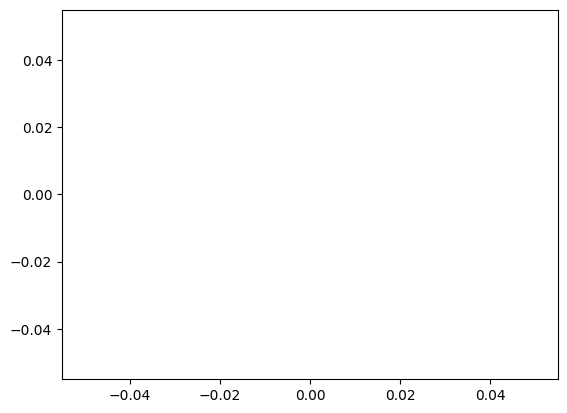

In [219]:
ax = sns.lineplot(x=list(range(start, len(delts)*step+start, step)), y=delts)


plt.savefig(f'{folder}/{filename_delts}_{name_exp}.png')


In [47]:
for i, size in enumerate(range(start, end, step)):
    print(f'size={size}, delta={delts[i]}')

size=4, delta=inf
size=14, delta=inf
size=24, delta=inf
size=34, delta=inf
size=44, delta=inf
size=54, delta=inf
size=64, delta=inf
size=74, delta=inf
size=84, delta=inf
size=94, delta=inf
size=104, delta=inf
size=114, delta=inf
size=124, delta=inf
size=134, delta=inf
size=144, delta=inf
size=154, delta=inf
size=164, delta=inf
size=174, delta=inf
size=184, delta=184.126
size=194, delta=inf
size=204, delta=inf
size=214, delta=inf
size=224, delta=inf
size=234, delta=inf
size=244, delta=inf
size=254, delta=inf
size=264, delta=202.824
size=274, delta=inf
size=284, delta=inf
size=294, delta=inf
size=304, delta=148.979
size=314, delta=inf
size=324, delta=inf
size=334, delta=inf
size=344, delta=inf
size=354, delta=inf
size=364, delta=inf
size=374, delta=162.235
size=384, delta=inf
size=394, delta=183.67
size=404, delta=inf
size=414, delta=96.693
size=424, delta=106.41
size=434, delta=104.129
size=444, delta=141.802
size=454, delta=106.343
size=464, delta=108.596
size=474, delta=inf
size=484, 

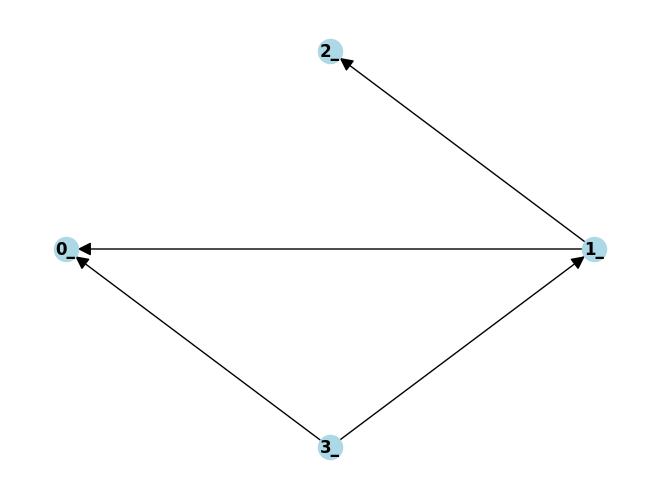

In [48]:
# создаем графическое представление
G = nx.DiGraph(G_sample.edges)
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', font_weight='bold', font_size=12, arrowsize=20)
plt.savefig(f'{folder}/{filename_train_structure}_{name_exp}.png')
plt.show()

In [343]:
# G = [['1_', '2_'], ['1_', '3_'], ['2_','3_']]
# N = 1000000
# gmm = GMM(n_components=2, priors=[0.5, 0.5], means=[[2], [28]], covariances=[[[1]],[[1]]])
# one_var = gmm.sample(N)
# two_var = 2*one_var + 10
# hree_var = -7 + 87*one_var + 20*two_var

# sample_init = pd.DataFrame(columns=['1_', '2_', '3_'], index=list(range(0,N)))
# sample_init['1_'] = one_var
# sample_init['2_'] = two_var
# sample_init['3_'] = three_var

In [344]:
(pd.DataFrame(delts)).to_csv(f'{folder}/delts_{name_exp}.csv')

In [345]:
G_sample.edges

OutEdgeView([('0_', '1_'), ('0_', '2_'), ('1_', '3_'), ('1_', '2_')])

In [346]:
G_sample.nodes

NodeView(('0_', '1_', '2_', '3_'))